### Imports

In [1]:

### Imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np
import os

from py_files.extract import extract_data, extract_metadata

from bycycle import features, cyclepoints, plts

from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import detrend

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum
import neurokit2 as nk

import sys
sys.path.append("../")
from scripts.funcs import *

from scipy.signal import correlate
from scipy.signal import welch

import fooof

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000

CROP_MIN = 10000
CROP_MAX = 15000
WINDOW_LENGTH = 5000
from py_files.extract import extract_data, extract_metadata
from py_files.simulate_ecg_sig import simulate_ecg_signal
from py_files.find_most_similar_ecg_signal import find_most_similar_signal

### Load Dat

In [2]:
# Data paths
dir_path = '/Users/morganfitzgerald/Projects/ecg_param/data'
files_dat = [i for i in sorted(os.listdir(dir_path)) if i.endswith('dat')]
files_hea = [i for i in sorted(os.listdir(dir_path)) if i.endswith('hea')]
# files_hea = [i for i in files_hea if i != '0400.hea'] # missing one participant's data
# Assuming files_dat is a list of filenames
# Iterate over the list
for filename in files_dat:
    # Extract subject number
    sub_num = os.path.splitext(filename)[0]
    
    # Ensure the extracted part is numeric (remove leading zeros)
    sub_num = str(int(sub_num))
    
    # Define SUB_NUM variable
    SUB_NUM = sub_num
    
    # Print the result
    print(f"Subject Number for {filename}: {SUB_NUM}")

Subject Number for 0001.dat: 1
Subject Number for 0002.dat: 2
Subject Number for 0006.dat: 6
Subject Number for 0007.dat: 7
Subject Number for 0008.dat: 8
Subject Number for 0009.dat: 9
Subject Number for 0010.dat: 10
Subject Number for 0011.dat: 11
Subject Number for 0020.dat: 20


### Select ECG Sig

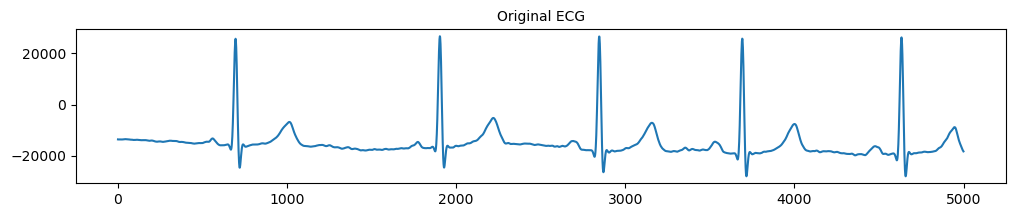

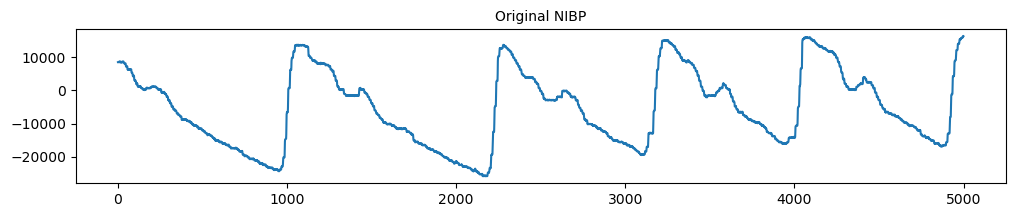

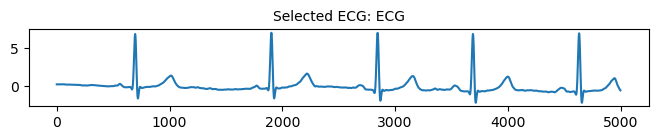

In [3]:
#PLOT THE RAW SIGNALS 

SUB_NUM = 2

# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[SUB_NUM]),
    os.path.join(dir_path, files_hea[SUB_NUM]),
    raw_dtype='int16'
)

# Iterate through signals and plot only the original signals
for ind in range(metadata['n_sigs']):
    plt.figure(figsize=(12, 2))

    # Original signal
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']
    original_signal = sigs[ind][CROP_MIN:CROP_MAX]
    
    plt.plot(original_signal)
    plt.title(f'Original {signal_name}', size=10)

plt.show()
#SELECT THE SIGNAL
# SUB_NUM = 1

# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[SUB_NUM]),
    os.path.join(dir_path, files_hea[SUB_NUM]),
    raw_dtype='int16'
)

# Template ECG signal
template_ecg = simulate_ecg_signal(duration=5, sampling_rate=1000, heart_rate=80, amplitude_factor=7, normalize=False)

# List to store normalized signals
normalized_signals = []

# Iterate through signals and normalize each
for ind in range(metadata['n_sigs']):
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']
    
    # Cut the signal shorter before normalization
    cropped_signal = sigs[ind][CROP_MIN:CROP_MAX]

    # Normalize the signal
    normalized_signal = (cropped_signal - np.mean(cropped_signal)) / np.std(cropped_signal)

    # Add normalized signal to the list
    normalized_signals.append(normalized_signal)


# Find the most similar signal to the template using cross-correlation
selected_signal, selected_signal_name, selected_signal_index = find_most_similar_signal(template_ecg, normalized_signals, metadata)

# Plot the most similar signal with the original signal name in the title
plt.figure(figsize=(8, 1))
plt.plot(selected_signal)
plt.title(f'Selected ECG: {selected_signal_name}', size=10)
plt.show()

# Now 'ecg' contains the selected signal
ecg = sigs[selected_signal_index]


## Simulating with Neurokit

### Simulate ECG Based on Real Gaussian Params

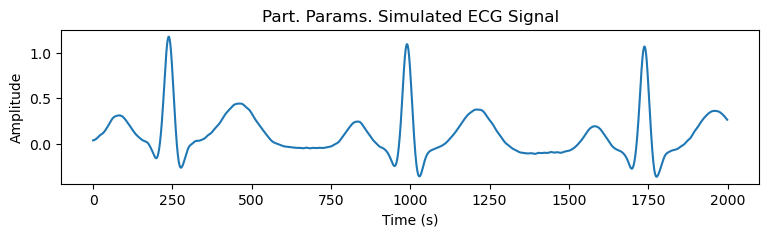

In [4]:
## Simulated ECG Signal
# import neurokit2 as nk
# import numpy as np
# import matplotlib.pyplot as plt



#These parameters are the average of one subject 
def simulate_ecg(duration=10, sampling_rate=1000, heart_rate=80, amplitude_factor=1.0,
                 p_peak_width=0.1, p_peak_height=0.2,
                 q_peak_width=0.05, q_peak_height=-0.1,
                 r_peak_width=0.08, r_peak_height=1.0,
                 s_peak_width=0.1, s_peak_height=-0.2,
                 t_peak_width=0.15, t_peak_height=0.25):
    """
    Simulates an ECG signal using the neurokit2 library.

    Parameters:
    - duration (float): Duration of the simulated ECG signal in seconds.
    - sampling_rate (int): Sampling rate of the ECG signal.
    - heart_rate (int): Heart rate of the simulated ECG signal in beats per minute.
    - amplitude_factor (float): Scaling factor for the amplitude of the simulated ECG signal.
    - p_peak_width (float): Width of the P peak.
    - p_peak_height (float): Height of the P peak.
    - q_peak_width (float): Width of the Q peak.
    - q_peak_height (float): Height of the Q peak.
    - r_peak_width (float): Width of the R peak.
    - r_peak_height (float): Height of the R peak.
    - s_peak_width (float): Width of the S peak.
    - s_peak_height (float): Height of the S peak.
    - t_peak_width (float): Width of the T peak.
    - t_peak_height (float): Height of the T peak.

    Returns:
    - numpy array: Simulated ECG signal.
    """
    sim_signal = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate,
                                 p_peak_width=p_peak_width, p_peak_height=p_peak_height,
                                 q_peak_width=q_peak_width, q_peak_height=q_peak_height,
                                 r_peak_width=r_peak_width, r_peak_height=r_peak_height,
                                 s_peak_width=s_peak_width, s_peak_height=s_peak_height,
                                 t_peak_width=t_peak_width, t_peak_height=t_peak_height)
    sim_ecg = sim_signal * amplitude_factor
    return sim_ecg


# Simulate and plot ECG
sim_signal = simulate_ecg(amplitude_factor=1)

CROP_MIN = 2000
CROP_MAX = 4000

#Plot the simulated siganl
plt.figure(figsize=(9, 2))
plt.plot(sim_signal[CROP_MIN:CROP_MAX])
plt.title('Part. Params. Simulated ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



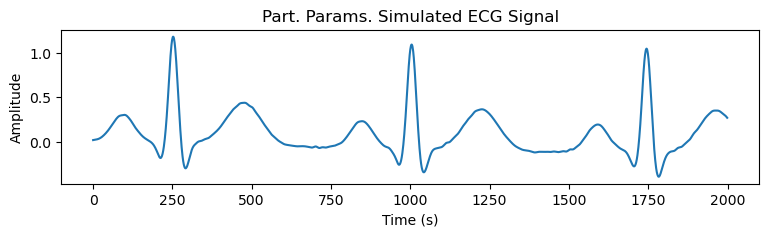

In [5]:
## Simulated ECG Signal
# import neurokit2 as nk
# import numpy as np
# import matplotlib.pyplot as plt



#These parameters are the average of one subject 
def simulate_ecg(duration=10, sampling_rate=1000, heart_rate=80, amplitude_factor=1.0, noise = 1,
                 p_peak_width=0.1, p_peak_height=0.2,
                 q_peak_width=0.05, q_peak_height=-0.1,
                 r_peak_width=0.08, r_peak_height=1.0,
                 s_peak_width=0.1, s_peak_height=-0.2,
                 t_peak_width=0.15, t_peak_height=0.25):

    """
    Simulates an ECG signal using the neurokit2 library.

    Parameters:
    - duration (float): Duration of the simulated ECG signal in seconds.
    - sampling_rate (int): Sampling rate of the ECG signal.
    - heart_rate (int): Heart rate of the simulated ECG signal in beats per minute.
    - amplitude_factor (float): Scaling factor for the amplitude of the simulated ECG signal.
    - p_peak_width (float): Width of the P peak.
    - p_peak_height (float): Height of the P peak.
    - q_peak_width (float): Width of the Q peak.
    - q_peak_height (float): Height of the Q peak.
    - r_peak_width (float): Width of the R peak.
    - r_peak_height (float): Height of the R peak.
    - s_peak_width (float): Width of the S peak.
    - s_peak_height (float): Height of the S peak.
    - t_peak_width (float): Width of the T peak.
    - t_peak_height (float): Height of the T peak.

    Returns:
    - numpy array: Simulated ECG signal.
    """
    sim_signal = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate,
                                 p_peak_width=p_peak_width, p_peak_height=p_peak_height,
                                 q_peak_width=q_peak_width, q_peak_height=q_peak_height,
                                 r_peak_width=r_peak_width, r_peak_height=r_peak_height,
                                 s_peak_width=s_peak_width, s_peak_height=s_peak_height,
                                 t_peak_width=t_peak_width, t_peak_height=t_peak_height)
    sim_ecg = sim_signal * amplitude_factor
    return sim_ecg


# Simulate and plot ECG
sim_signal = simulate_ecg(amplitude_factor=1)

CROP_MIN = 2000
CROP_MAX = 4000

#Plot the simulated siganl
plt.figure(figsize=(9, 2))
plt.plot(sim_signal[CROP_MIN:CROP_MAX])
plt.title('Part. Params. Simulated ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



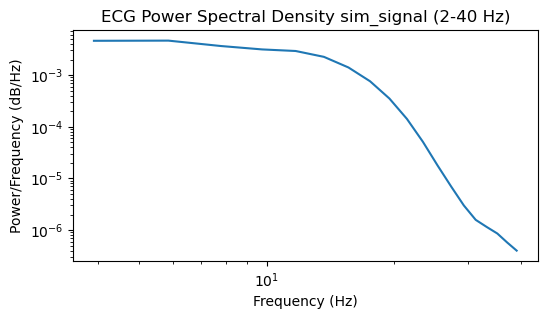


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

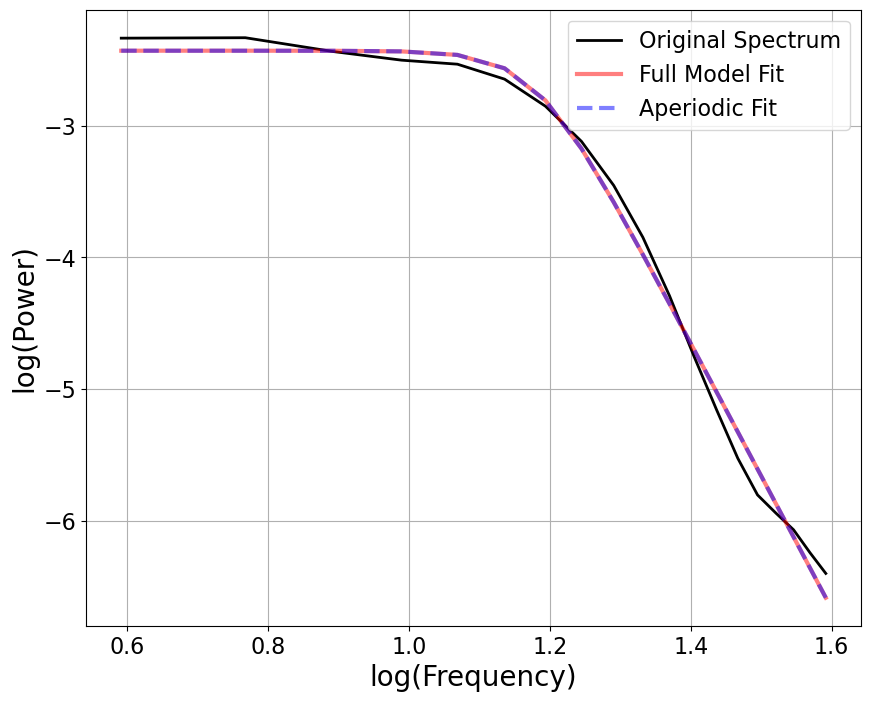

In [5]:
#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage


# Calculate the Power Spectral Density (PSD) using Welch's method
f, Pxx = welch(sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Limit the plot to the frequency range of 2-40 Hz
freq_range_mask = (f >= 2) & (f <= 40)
f_trimmed = f[freq_range_mask]
Pxx_trimmed = Pxx[freq_range_mask]

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space for the specified frequency range
plt.loglog(f_trimmed, Pxx_trimmed)
plt.title(f'ECG Power Spectral Density sim_signal (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

# Apply FOOOF to the trimmed PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_trimmed, Pxx_trimmed)
fg.report(plt_log=True)

### Wide Peaks 

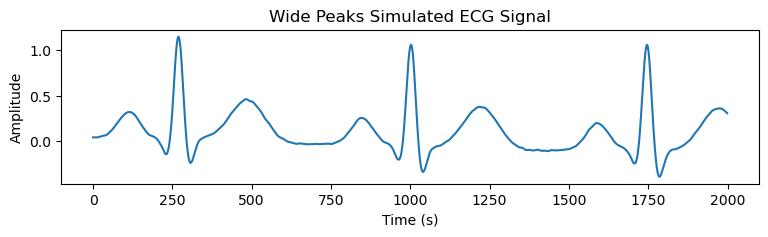

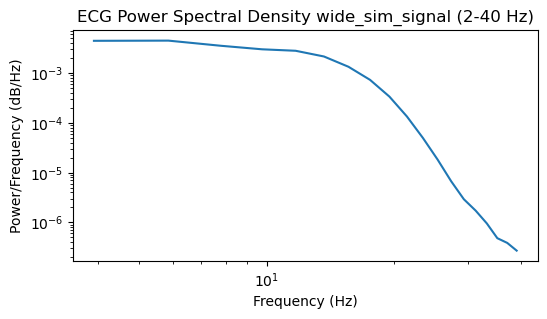


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

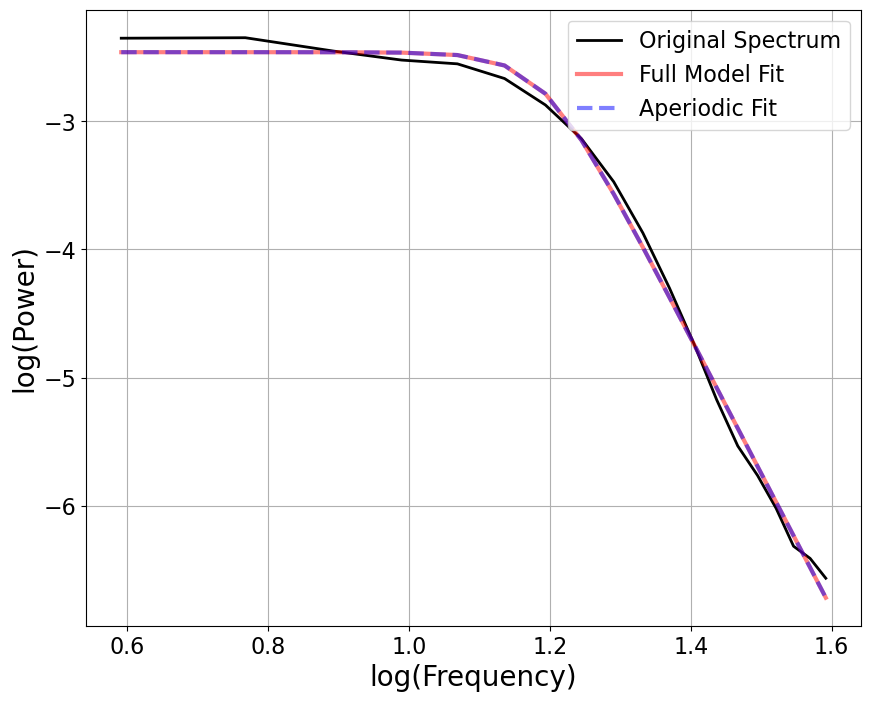

In [6]:

# Simulate and plot ECG
wide_sim_signal = simulate_ecg(amplitude_factor=1, 
                          p_peak_width=0.5, p_peak_height=0.2,
                 q_peak_width=0.25, q_peak_height=-0.1,
                 r_peak_width=0.5, r_peak_height=1.0,
                 s_peak_width=0.5, s_peak_height=-0.2,
                 t_peak_width=0.75, t_peak_height=0.25)

#Plot the simulated siganl
plt.figure(figsize=(9, 2))
plt.plot(wide_sim_signal[CROP_MIN:CROP_MAX])
plt.title('Wide Peaks Simulated ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage


# Calculate the Power Spectral Density (PSD) using Welch's method
f, Pxx = welch(wide_sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Limit the plot to the frequency range of 2-40 Hz
freq_range_mask = (f >= 2) & (f <= 40)
f_trimmed = f[freq_range_mask]
Pxx_trimmed = Pxx[freq_range_mask]

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space for the specified frequency range
plt.loglog(f_trimmed, Pxx_trimmed)
plt.title(f'ECG Power Spectral Density wide_sim_signal (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

# Apply FOOOF to the trimmed PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_trimmed, Pxx_trimmed)
fg.report(plt_log=True)

### Narrow Peaks

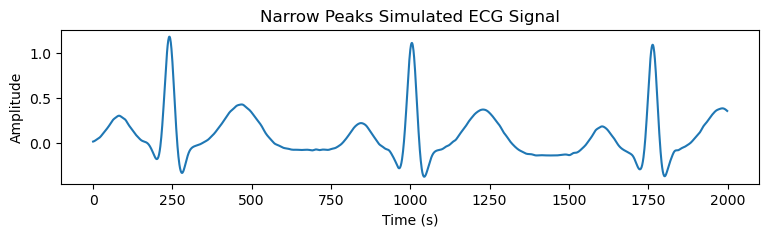

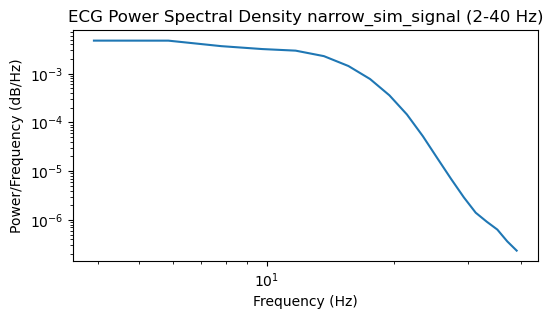


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

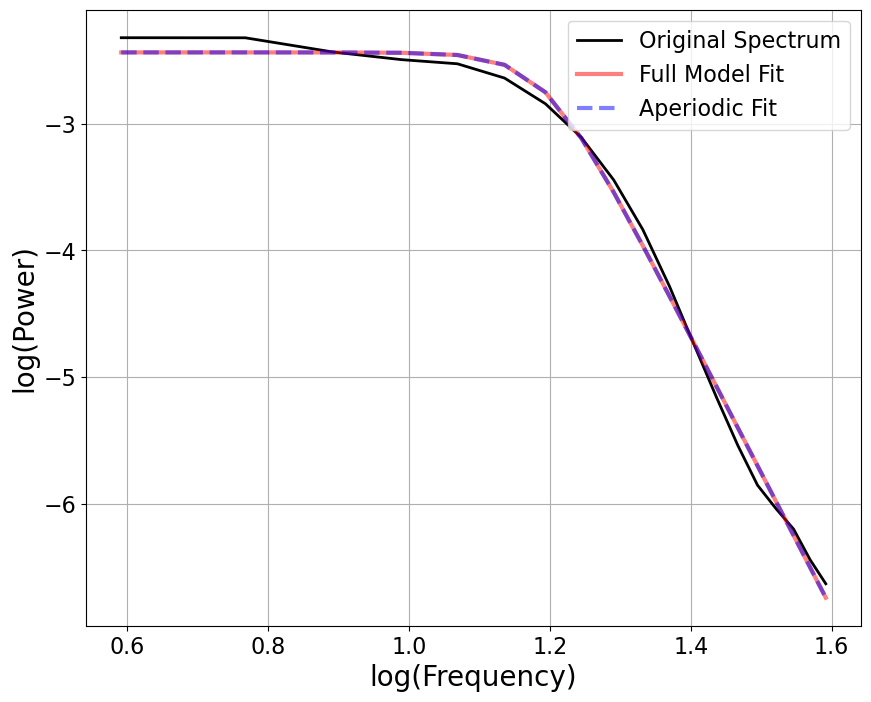

In [7]:
## Simulated ECG Signal
# import neurokit2 as nk
# import numpy as np
# import matplotlib.pyplot as plt

# Simulate and plot ECG
narrow_sim_signal = simulate_ecg( 
                amplitude_factor=1.0,
                 p_peak_width=0.05, p_peak_height=0.2,
                 q_peak_width=0.025, q_peak_height=-0.1,
                 r_peak_width=0.04, r_peak_height=1.0,
                 s_peak_width=0.05, s_peak_height=-0.2,
                 t_peak_width=0.075, t_peak_height=0.25)

#Plot the simulated siganl
plt.figure(figsize=(9, 2))
plt.plot(narrow_sim_signal[CROP_MIN:CROP_MAX])
plt.title('Narrow Peaks Simulated ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage


# Calculate the Power Spectral Density (PSD) using Welch's method
f, Pxx = welch(narrow_sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Limit the plot to the frequency range of 2-40 Hz
freq_range_mask = (f >= 2) & (f <= 40)
f_trimmed = f[freq_range_mask]
Pxx_trimmed = Pxx[freq_range_mask]

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space for the specified frequency range
plt.loglog(f_trimmed, Pxx_trimmed)
plt.title(f'ECG Power Spectral Density narrow_sim_signal (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

# Apply FOOOF to the trimmed PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_trimmed, Pxx_trimmed)
fg.report(plt_log=True)

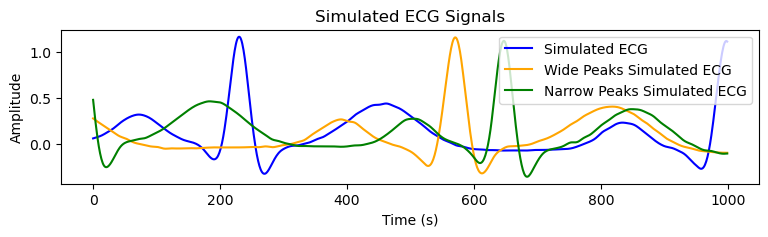

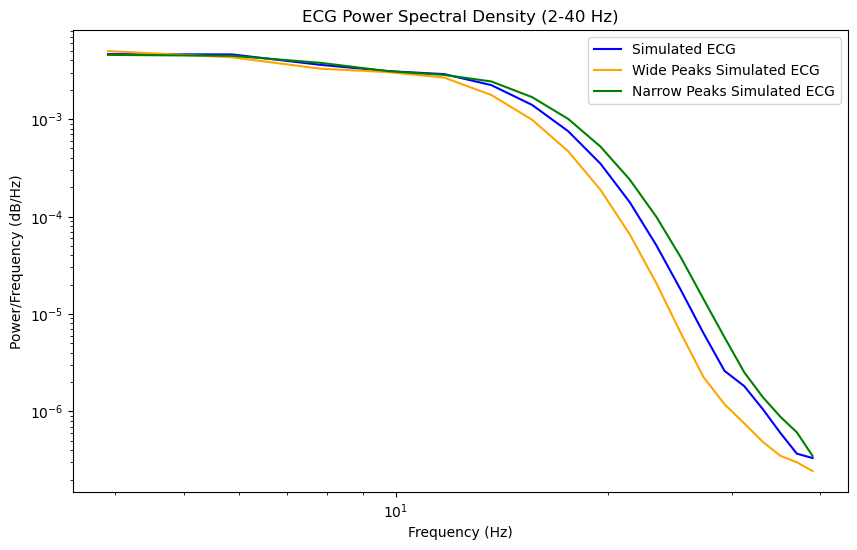

In [8]:
# Simulate and plot ECG
sim_signal = simulate_ecg(amplitude_factor=1)
wide_sim_signal = simulate_ecg(amplitude_factor=1, heart_rate = 70, 
                          p_peak_width=0.5, p_peak_height=0.2,
                          q_peak_width=0.25, q_peak_height=-0.1,
                          r_peak_width=0.5, r_peak_height=1.0,
                          s_peak_width=0.5, s_peak_height=-0.2,
                          t_peak_width=0.75, t_peak_height=0.25)

# Simulate narrow signal
narrow_sim_signal = simulate_ecg(amplitude_factor=1, heart_rate = 90, 
                                p_peak_width=0.1, p_peak_height=0.2,
                                q_peak_width=0.05, q_peak_height=-0.1,
                                r_peak_width=0.08, r_peak_height=1.0,
                                s_peak_width=0.1, s_peak_height=-0.2,
                                t_peak_width=0.15, t_peak_height=0.25)

CROP_MIN = 2000
CROP_MAX = 3000

# Plot the simulated signals
plt.figure(figsize=(9, 2))
plt.plot(sim_signal[CROP_MIN:CROP_MAX], label='Simulated ECG', color='blue')
plt.plot(wide_sim_signal[CROP_MIN:CROP_MAX], label='Wide Peaks Simulated ECG', color='orange')
plt.plot(narrow_sim_signal[CROP_MIN:CROP_MAX], label='Narrow Peaks Simulated ECG', color='green')
plt.title('Simulated ECG Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

# Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Calculate the Power Spectral Density (PSD) using Welch's method for sim_signal
f_sim, Pxx_sim = welch(sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Calculate the Power Spectral Density (PSD) using Welch's method for wide_sim_signal
f_wide, Pxx_wide = welch(wide_sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Calculate the Power Spectral Density (PSD) using Welch's method for narrow_sim_signal
f_narrow, Pxx_narrow = welch(narrow_sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Limit the plot to the frequency range of 2-40 Hz for all signals
freq_range_mask_sim = (f_sim >= 2) & (f_sim <= 40)
f_trimmed_sim = f_sim[freq_range_mask_sim]
Pxx_trimmed_sim = Pxx_sim[freq_range_mask_sim]

freq_range_mask_wide = (f_wide >= 2) & (f_wide <= 40)
f_trimmed_wide = f_wide[freq_range_mask_wide]
Pxx_trimmed_wide = Pxx_wide[freq_range_mask_wide]

freq_range_mask_narrow = (f_narrow >= 2) & (f_narrow <= 40)
f_trimmed_narrow = f_narrow[freq_range_mask_narrow]
Pxx_trimmed_narrow = Pxx_narrow[freq_range_mask_narrow]

# Plot the Power Spectral Density (PSD) in log-log space for all signals on the same graph
plt.figure(figsize=(10, 6))

plt.loglog(f_trimmed_sim, Pxx_trimmed_sim, label='Simulated ECG', color='blue')
plt.loglog(f_trimmed_wide, Pxx_trimmed_wide, label='Wide Peaks Simulated ECG', color='orange')
plt.loglog(f_trimmed_narrow, Pxx_trimmed_narrow, label='Narrow Peaks Simulated ECG', color='green')

plt.title('ECG Power Spectral Density (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend(loc='upper right')
plt.show()



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                  

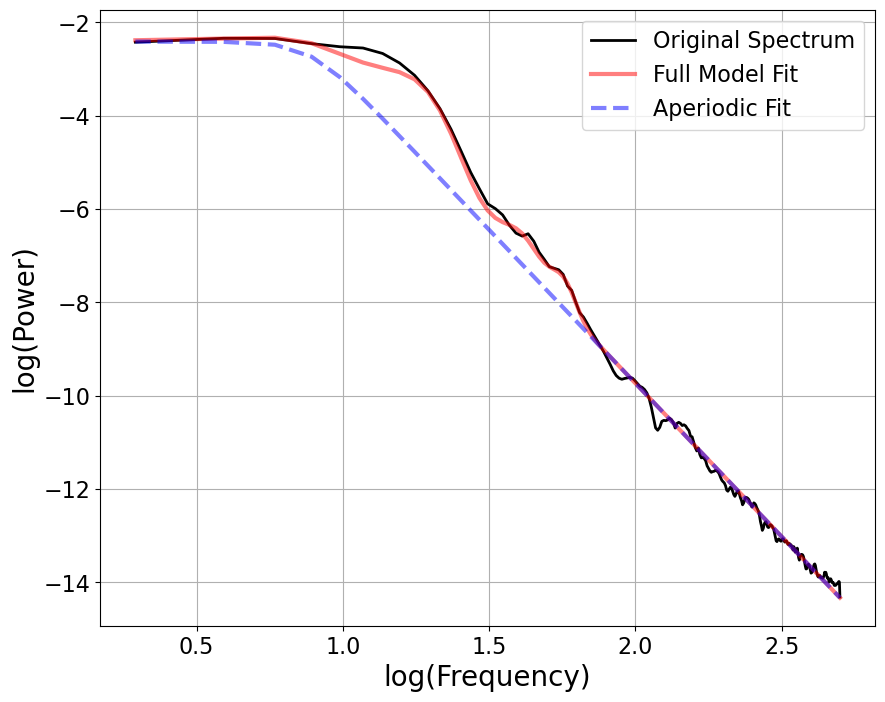

In [50]:
# Apply FOOOF to the sim_sig PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_sim, Pxx_sim)
fg.report(plt_log=True)


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                  

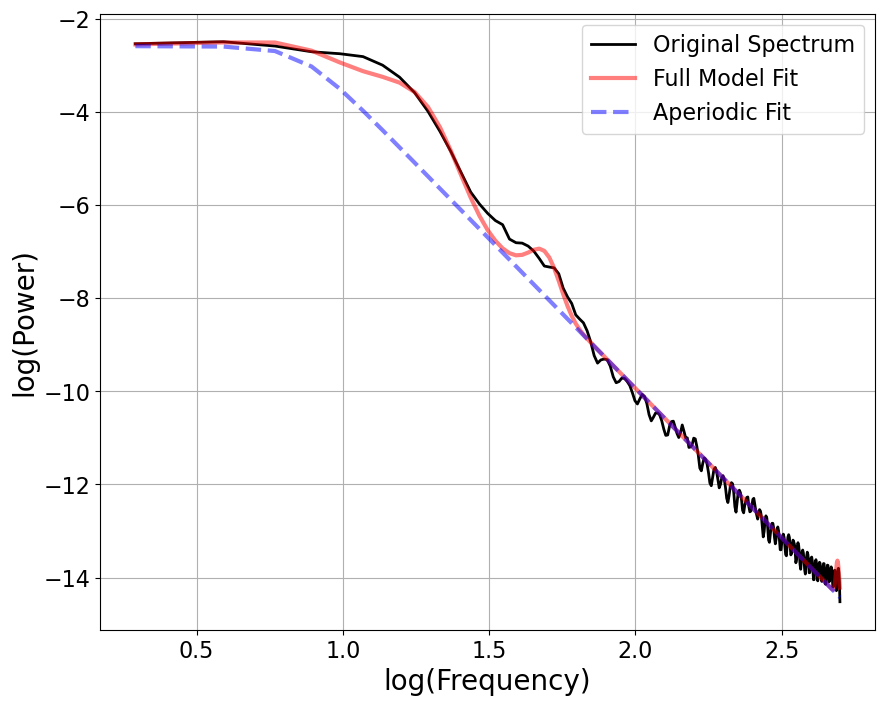

In [51]:
# Apply FOOOF to the wide PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_wide, Pxx_wide)
fg.report(plt_log=True)



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                  

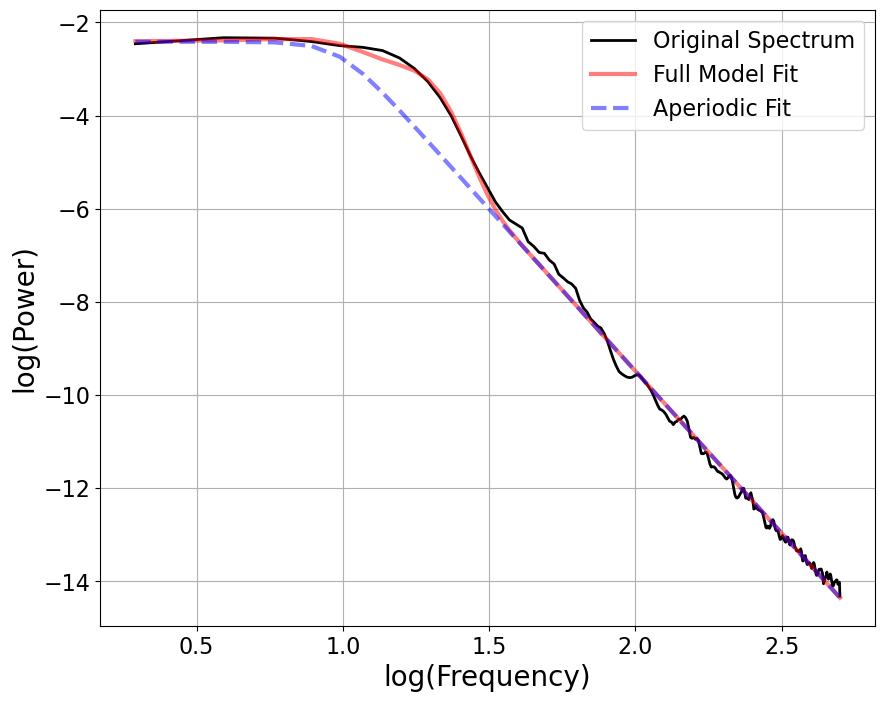

In [52]:
# Apply FOOOF to the narrow PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_narrow, Pxx_narrow)
fg.report(plt_log=True)

### Change the freq lim


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

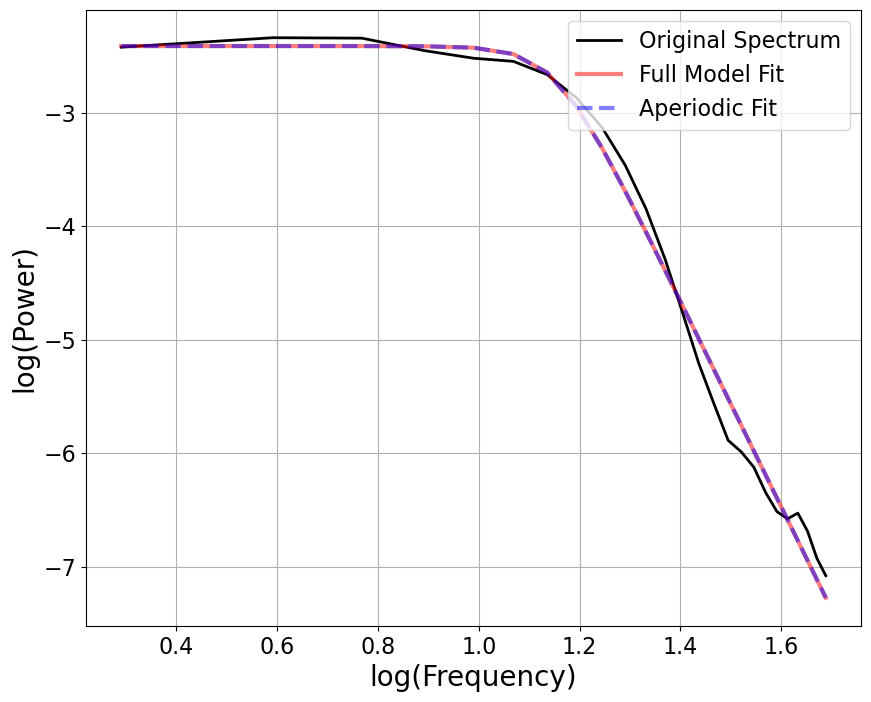

In [56]:

# Set your desired upper frequency limit
upper_freq_limit = 50  # Replace with your desired upper frequency limit

# Create a FOOOF object with the desired parameters
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')

# Fit the power spectrum with the specified frequency range
fg.fit(f_sim, Pxx_sim, freq_range=(0.5, upper_freq_limit))

# Report the results
fg.report(plt_log=True)


### Change only the BPM

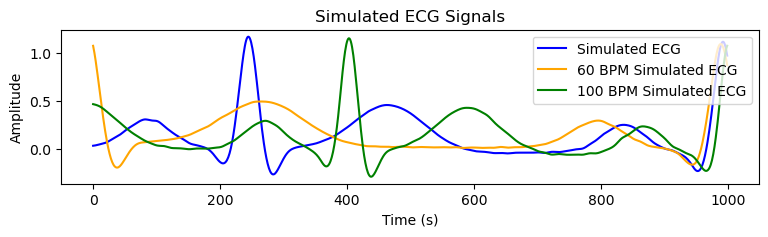

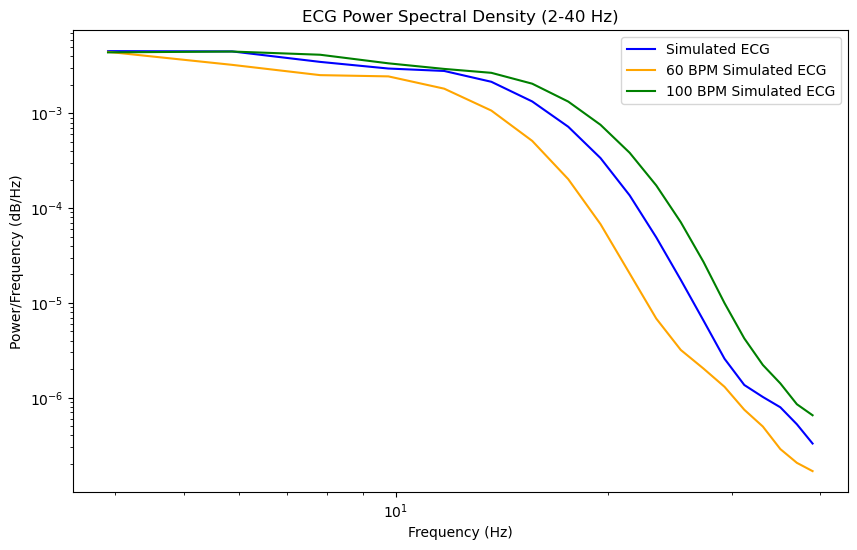

In [6]:
# Simulate and plot ECG
sim_signal = simulate_ecg(amplitude_factor=1)

sim_signal_NARROWBPM = simulate_ecg(amplitude_factor=1, heart_rate = 100, 
                        p_peak_width=0.1, p_peak_height=0.2,
                 q_peak_width=0.05, q_peak_height=-0.1,
                 r_peak_width=0.08, r_peak_height=1.0,
                 s_peak_width=0.1, s_peak_height=-0.2,
                 t_peak_width=0.15, t_peak_height=0.25)
# Simulate narrow signal
sim_signal_WIDEBPM = simulate_ecg(amplitude_factor=1, heart_rate = 60, 
                                  p_peak_width=0.1, p_peak_height=0.2,
                 q_peak_width=0.05, q_peak_height=-0.1,
                 r_peak_width=0.08, r_peak_height=1.0,
                 s_peak_width=0.1, s_peak_height=-0.2,
                 t_peak_width=0.15, t_peak_height=0.25)
CROP_MIN = 2000
CROP_MAX = 3000

# Plot the simulated signals
plt.figure(figsize=(9, 2))
plt.plot(sim_signal[CROP_MIN:CROP_MAX], label='Simulated ECG', color='blue')
plt.plot(sim_signal_WIDEBPM[CROP_MIN:CROP_MAX], label='60 BPM Simulated ECG', color='orange')
plt.plot(sim_signal_NARROWBPM[CROP_MIN:CROP_MAX], label='100 BPM Simulated ECG', color='green')
plt.title('Simulated ECG Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

# Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Calculate the Power Spectral Density (PSD) using Welch's method for sim_signal
f_sim, Pxx_sim = welch(sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Calculate the Power Spectral Density (PSD) using Welch's method for wide_sim_signal
f_wide, Pxx_wide = welch(sim_signal_WIDEBPM, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Calculate the Power Spectral Density (PSD) using Welch's method for narrow_sim_signal
f_narrow, Pxx_narrow = welch(sim_signal_NARROWBPM, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Limit the plot to the frequency range of 2-40 Hz for all signals
freq_range_mask_sim = (f_sim >= 2) & (f_sim <= 40)
f_trimmed_sim = f_sim[freq_range_mask_sim]
Pxx_trimmed_sim = Pxx_sim[freq_range_mask_sim]

freq_range_mask_wide = (f_wide >= 2) & (f_wide <= 40)
f_trimmed_wide = f_wide[freq_range_mask_wide]
Pxx_trimmed_wide = Pxx_wide[freq_range_mask_wide]

freq_range_mask_narrow = (f_narrow >= 2) & (f_narrow <= 40)
f_trimmed_narrow = f_narrow[freq_range_mask_narrow]
Pxx_trimmed_narrow = Pxx_narrow[freq_range_mask_narrow]

# Plot the Power Spectral Density (PSD) in log-log space for all signals on the same graph
plt.figure(figsize=(10, 6))

plt.loglog(f_trimmed_sim, Pxx_trimmed_sim, label='Simulated ECG', color='blue')
plt.loglog(f_trimmed_wide, Pxx_trimmed_wide, label='60 BPM Simulated ECG', color='orange')
plt.loglog(f_trimmed_narrow, Pxx_trimmed_narrow, label='100 BPM Simulated ECG', color='green')

plt.title('ECG Power Spectral Density (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend(loc='upper right')
plt.show()


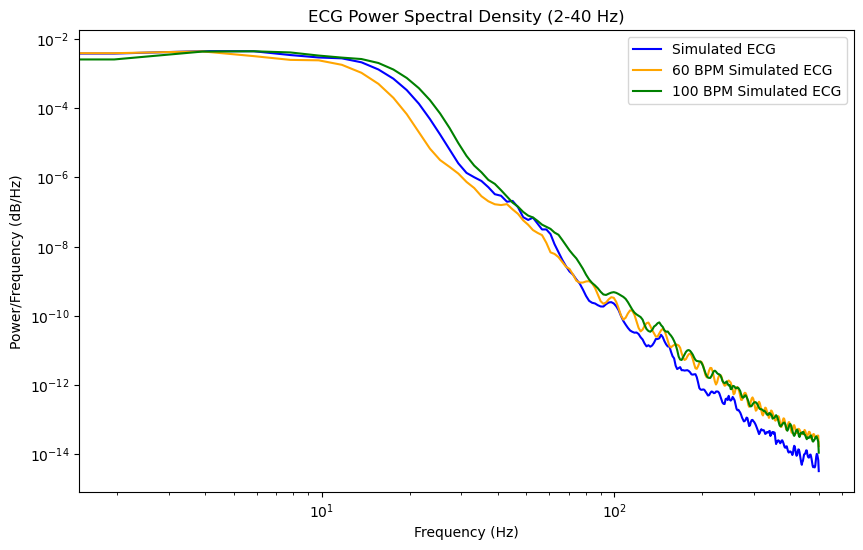

In [7]:


# Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Calculate the Power Spectral Density (PSD) using Welch's method for sim_signal
f_sim, Pxx_sim = welch(sim_signal, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Calculate the Power Spectral Density (PSD) using Welch's method for wide_sim_signal
f_wide, Pxx_wide = welch(sim_signal_WIDEBPM, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Calculate the Power Spectral Density (PSD) using Welch's method for narrow_sim_signal
f_narrow, Pxx_narrow = welch(sim_signal_NARROWBPM, fs=1000, nperseg=nperseg, noverlap=noverlap)

# # Limit the plot to the frequency range of 2-40 Hz for all signals
# freq_range_mask_sim = (f_sim >= 2) & (f_sim <= 40)
# f_trimmed_sim = f_sim[freq_range_mask_sim]
# Pxx_trimmed_sim = Pxx_sim[freq_range_mask_sim]

# freq_range_mask_wide = (f_wide >= 2) & (f_wide <= 40)
# f_trimmed_wide = f_wide[freq_range_mask_wide]
# Pxx_trimmed_wide = Pxx_wide[freq_range_mask_wide]

# freq_range_mask_narrow = (f_narrow >= 2) & (f_narrow <= 40)
# f_trimmed_narrow = f_narrow[freq_range_mask_narrow]
# Pxx_trimmed_narrow = Pxx_narrow[freq_range_mask_narrow]

# Plot the Power Spectral Density (PSD) in log-log space for all signals on the same graph
plt.figure(figsize=(10, 6))

plt.loglog(f_sim, Pxx_sim, label='Simulated ECG', color='blue')
plt.loglog(f_wide, Pxx_wide, label='60 BPM Simulated ECG', color='orange')
plt.loglog(f_narrow, Pxx_narrow, label='100 BPM Simulated ECG', color='green')

plt.title('ECG Power Spectral Density (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend(loc='upper right')
plt.show()


## Poisson Simulation

In [ ]:
#Code here from R_based_fitting